# Efeito do tamanho da amostra na validação cruzada

No caderno anterior, apresentamos a estrutura geral de validação cruzada
e como avaliar se um modelo preditivo é underfiting, overfitting ou
generalizando. Além desses aspectos, também é importante entender como
os diferentes erros são influenciados pelo número de amostras disponíveis.

Neste caderno, mostraremos esse aspecto observando a variabilidade de
os diferentes erros.

Vamos primeiro carregar os dados e criar o mesmo modelo do anterior
caderno.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Se você quiser uma visão geral mais aprofundada sobre este conjunto de dados, pode consultar o
Appendix - Datasets seção de descrição no final deste MOOC.</p>
</div>

In [2]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

## Curva de aprendizado

Para entender o impacto do número de amostras disponíveis para treinamento em
o desempenho estatístico de um modelo preditivo, é possível
reduzir sinteticamente o número de amostras usadas para treinar o modelo preditivo
e verifique os erros de treinamento e teste.

Portanto, podemos variar o número de amostras no conjunto de treinamento e repetir
o experimento. As pontuações de treinamento e teste podem ser plotadas de forma semelhante a
a curva de validação, mas em vez de variar um hiperparâmetro, variamos o
número de amostras de treinamento. Essa curva é chamada de ** curva de aprendizado **.

Ele fornece informações sobre o benefício de adicionar novos exemplos de treinamento
para melhorar o desempenho estatístico de um modelo.

Vamos calcular a curva de aprendizado para uma árvore de decisão e variar o
proporção do treinamento definido de 10% a 100%.

In [3]:
import numpy as np
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

Usaremos uma validação cruzada `ShuffleSplit` para avaliar nosso modelo preditivo.

In [4]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)

Agora, estamos prontos para realizar o experimento.

In [5]:
from sklearn.model_selection import learning_curve

results = learning_curve(
    regressor, data, target, train_sizes=train_sizes, cv=cv,
    scoring="neg_mean_absolute_error", n_jobs=2)
train_size, train_scores, test_scores = results[:3]
# Convert the scores into errors
train_errors, test_errors = -train_scores, -test_scores

Agora, podemos traçar a curva.

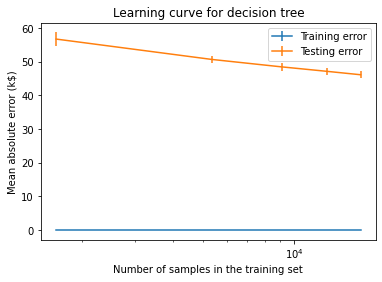

In [7]:
import matplotlib.pyplot as plt

plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training error")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Testing error")
plt.legend()

plt.xscale("log")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Learning curve for decision tree")

Olhando apenas para o erro de treinamento, vemos que obtemos um erro de 0 k $. Isto
significa que o modelo treinado (ou seja, árvore de decisão) está claramente superando o
dados de treinamento.

Olhando apenas para o erro de teste, observamos que quanto mais amostras são
adicionado ao conjunto de treinamento, menor será o erro de teste. Nós também
estão procurando o platô do erro de teste para o qual não há
benefício em adicionar mais amostras ou avaliar o ganho potencial de adicionar
mais amostras no conjunto de treinamento.

Se atingirmos um platô e adicionar novas amostras no conjunto de treinamento não
reduzir o erro de teste, podemos ter alcançado a taxa de erro de Bayes usando o
modelo disponível. Usar um modelo mais complexo pode ser a única possibilidade de
reduza ainda mais o erro de teste.

## Resumo

No caderno, aprendemos:

* a influência do número de amostras em um conjunto de dados, especialmente no
  variabilidade dos erros relatados ao executar a validação cruzada;
* sobre a curva de aprendizado que é uma representação visual da capacidade
  de um modelo para melhorar adicionando novas amostras.

# 📝 Exercício M2.01

O objetivo deste exercício é fazer os seguintes experimentos:

* treinar e testar um classificador de máquina de vetor de suporte por meio de
  validação cruzada;
* estudar o efeito do parâmetro gama deste classificador usando um
  curva de validação;
* estudar se seria útil em termos de classificação se pudéssemos adicionar novos
  amostras no conjunto de dados usando uma curva de aprendizado.

Para fazer esses experimentos, primeiro carregaremos o conjunto de dados de transfusão de sangue.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Se você quiser uma visão geral mais aprofundada sobre este conjunto de dados, pode consultar o
Appendix - Datasets seção de descrição no final deste MOOC.</p>
</div>

In [ ]:
import pandas as pd
from urllib.request import urlretrieve 

In [12]:
url = 'https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/end-of-v1.0-session/datasets/blood_transfusion.csv'
urlretrieve(url, 'C:/Users/Rogerio Lopes/Desktop/Rogerio/MachineLearningWithCreatorsScikitLearn/Module2_Selecting_the_best_model/blood_transfusion.csv')

('C:/Users/Rogerio Lopes/Desktop/Rogerio/MachineLearningWithCreatorsScikitLearn/Module2_Selecting_the_best_model/blood_transfusion.csv',
 <http.client.HTTPMessage at 0x22d42ba1f40>)

In [14]:
blood_transfusion = pd.read_csv("blood_transfusion.csv")
blood_transfusion.head(3)

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,donated
1,0,13,3250,28,donated
2,1,16,4000,35,donated


In [15]:
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

Usaremos um classificador de máquina de vetor de suporte (SVM). Em sua forma mais simples
forma, um classificador SVM é um classificador linear que se comporta de forma semelhante a um
regressão logística. Na verdade, a otimização usada para encontrar o ótimo
pesos do modelo linear são diferentes, mas não precisamos saber esses
detalhes para o exercício.

Além disso, este classificador pode se tornar mais flexível / expressivo usando um
o chamado kernel que faz o modelo se torna não linear. Novamente, nenhum requisito
em relação à matemática é necessário para realizar este exercício.

Usaremos um kernel RBF onde um parâmetro `gamma` permite ajustar o
flexibilidade do modelo.

Primeiro, vamos criar um pipeline preditivo feito de:

* a [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  with default parameter;
* a [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

onde o parâmetro `kernel` pode ser definido como` "rbf" `. Observe que este é o
  padrão.

In [16]:
# Write your code here.
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC())
model

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

Avalie o desempenho estatístico do seu modelo por validação cruzada com um
Esquema `ShuffleSplit`. Assim, você pode usar
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
e passe um [`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
para o parâmetro `cv`. Apenas corrija o `random_state = 0` no` ShuffleSplit`
e deixe os outros parâmetros para o padrão.

In [17]:
# Write your code here.
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(random_state=0)
cv_results = cross_validate(model, data, target, cv=cv, n_jobs=2)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.014999,0.004000,0.680000
1,0.014999,0.003062,0.746667
2,0.016999,0.004000,0.786667
3,0.015999,0.004000,0.800000
4,0.014501,0.003494,0.746667
5,0.013999,0.002999,0.786667
6,0.011995,0.004002,0.800000
7,0.011999,0.003002,0.826667
8,0.011994,0.003000,0.746667
9,0.012843,0.003000,0.733333


In [18]:
print(
    f"Accuracy score of our model:\n"
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}"
)

Accuracy score of our model:
0.765 +/- 0.043


Como mencionado anteriormente, o parâmetro `gamma` é um dos parâmetros
controlar sub / sobreajuste na máquina de vetores de suporte com um kernel RBF.

Calcule a curva de validação
(usando [`sklearn.model_selection.validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html))
para avaliar o efeito do parâmetro `gamma`. Você pode variar seu valor
entre `10e-3` e` 10e2` gerando amostras em uma escala logarítmica.
Assim, você pode usar `np.logspace (-3, 2, num = 30)`.

Uma vez que estamos manipulando um `Pipeline`, o nome do parâmetro será definido como
`svc__gamma` em vez de apenas` gamma`. Você pode recuperar o nome do parâmetro
usando `model.get_params (). keys ()`. Iremos entrar em detalhes sobre
acessar e definir hiperparâmetros na próxima seção.

In [19]:
# Write your code here.
import numpy as np
from sklearn.model_selection import validation_curve

gammas = np.logspace(-3, 2, num=30)
param_name = "svc__gamma"
train_scores, test_scores = validation_curve(
    model, data, target, param_name=param_name, param_range=gammas, cv=cv,
    n_jobs=2)

Trace a curva de validação para as pontuações do trem e do teste.

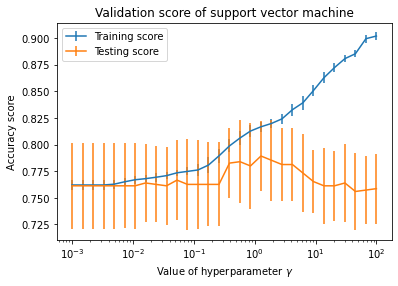

In [20]:
import matplotlib.pyplot as plt
plt.errorbar(gammas, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(gammas, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label='Testing score')
plt.legend()

plt.xscale("log")
plt.xlabel(r"Value of hyperparameter $\gamma$")
plt.ylabel("Accuracy score")
_ = plt.title("Validation score of support vector machine")

Olhando para a curva, podemos identificar claramente o regime de sobreajuste do classificador SVC quando gama> 1. A melhor configuração é em torno de gama = 1, enquanto para gama <1, não é muito claro se o classificador está subajustado, mas a pontuação do teste é pior do que para gama = 1.

Agora, você pode realizar uma análise para verificar se está adicionando novas amostras ao
conjunto de dados pode ajudar nosso modelo a generalizar melhor. Calcule a curva de aprendizado
(usando [`sklearn.model_selection.learning_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html))
calculando as pontuações do trem e do teste para diferentes tamanhos de conjunto de dados de treinamento.
Trace as pontuações do trem e do teste em relação ao número de amostras.

In [21]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1, num=10)
results = learning_curve(
    model, data, target, train_sizes=train_sizes, cv=cv, n_jobs=2)
train_size, train_scores, test_scores = results[:3]

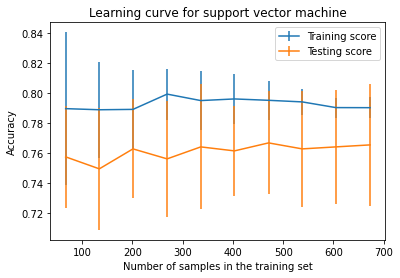

In [22]:
plt.errorbar(train_size, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(train_size, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label='Testing score')
plt.legend()

plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
_ = plt.title("Learning curve for support vector machine")